In [1]:
import json
import requests
import re
from datetime import datetime, timedelta, timezone

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
REPOS = [
    "datamole-ai/edvart",
    "keboola/python-component",
    "json-editor/json-editor",
    "astanin/python-tabulate",
    "angular/angular",
    "facebook/react",
    "Significant-Gravitas/AutoGPT",
    "freeCodeCamp/freeCodeCamp"
]

NOW = datetime.now(timezone.utc).replace(tzinfo=None)
WEEK_AGO = NOW - timedelta(days=7)
CSV_HEADERS = ["repo", "event_id", "event_type", "user", "created_at"]
CSV_PATH = "github_events.csv"
CSV_INDEX = ["repo", "event_id"]

NOW, WEEK_AGO

(datetime.datetime(2024, 8, 7, 20, 50, 22, 116620),
 datetime.datetime(2024, 7, 31, 20, 50, 22, 116620))

In [3]:
def get_github_events(repo, max_date):

    with open("credentials.json", 'r') as file:
        creds = json.load(file)
    TOKEN = creds["api_token"]
    
    if not bool(re.match(r"^[a-zA-Z-]+/[a-zA-Z-]+$", repo)):
        # validate if repo name is valid
        raise ValueError(f"The input string '{repo}' is not a valid repo.")
        # other checks: request the repo name if it's valid, etc.

    url = f"https://api.github.com/repos/{repo}/events"

    out_data = []
    out_data_headers = CSV_HEADERS
    
    url = f"https://api.github.com/repos/{repo}/events"

    headers = {
      'Accept': 'application/vnd.github+json',
      'X-GitHub-Api-Version': '2022-11-28',
      'Authorization': f"Bearer {TOKEN}"
    }

    max_events, page, per_page = 0, 1, 50
    while max_events < 500: 
    
        response = requests.request("GET", url, headers=headers, params={"per_page": per_page, "page": page})
    
        # print(response.text)
        response_parsed = json.loads(response.content.decode('utf-8'))
    
        for elem in response_parsed:
            out_data.append([repo, elem["id"], elem["type"], elem["actor"]["login"], elem["created_at"]])

        if len(response_parsed) < per_page:
            # don't need another requets
            break
        if datetime.strptime(out_data[-1][-1], "%Y-%m-%dT%H:%M:%SZ") < max_date:
            # the last event is older then a week
            break
        else:
            max_events += per_page
            page += 1
            

    df = pd.DataFrame(out_data, columns=out_data_headers)
    df["created_at"] = pd.to_datetime(df["created_at"])
    df["event_id"] = df["event_id"].astype(np.int64)
    df = df[df["created_at"].dt.tz_convert(None) >= max_date]
    
    return df

In [4]:
def event_chart(df, repo=""):
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(df["event_type"], df["avg_hours_between_events_hours"], color='green')
    plt.xlabel('Event Type')
    plt.ylabel('Average Time (hours) Between Events')
    plt.title(f"{repo} - Average Time Between Events by Event Type")
    plt.xticks(rotation=45, ha="right")  # Rotates x-axis labels for better readability if needed
    
    # Format y-axis values as hours
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}h'))
    plt.show()

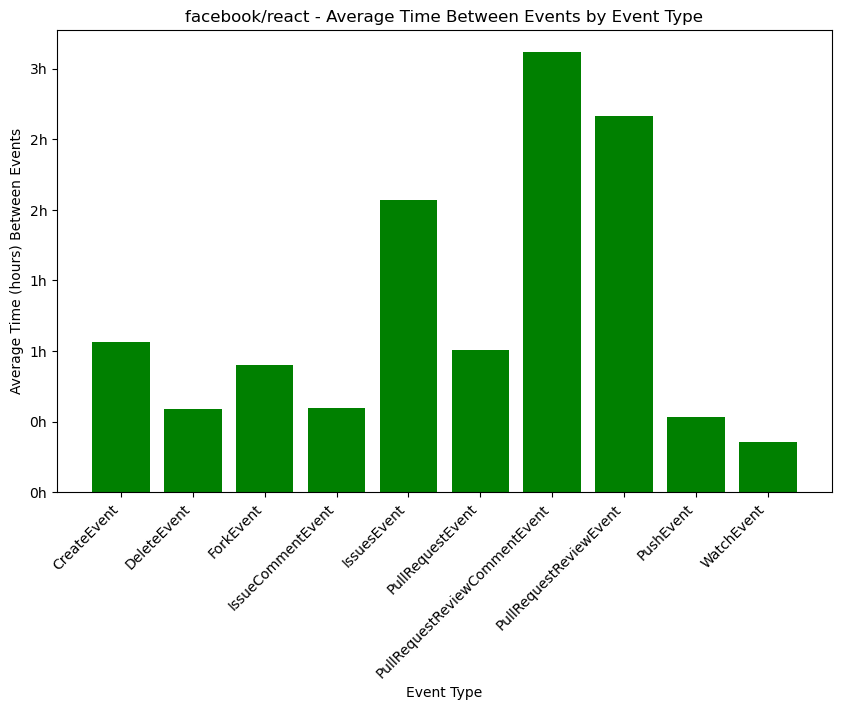

In [5]:
repo = "facebook/react"
# repo = "freeCodeCamp/freeCodeCamp"
# repo = "datamole-ai/edvart"

# reading events I've allready downloaded for given repo
# this is definetelly not an optimal solution to use pandas / csv here
# use pyspark / SQL database
df_hist = pd.read_csv(CSV_PATH, dtype={"event_id": np.int64}, parse_dates=["created_at"])
df_hist_repo = df_hist[df_hist["repo"] == repo]

if df_hist_repo.shape[0] == 0:
    repo_max_date = WEEK_AGO
else:
    repo_max_date = df_hist_repo["created_at"].dt.tz_convert(None).max()

df = get_github_events(repo, max_date=repo_max_date)

# concat history data and currently downloaded data
# and drop duplicates by primary key
df_hist_repo.set_index(CSV_INDEX, inplace=True)
df.set_index(CSV_INDEX, inplace=True)
df_repo_all = pd.concat([df_hist_repo.reset_index(), df.reset_index()]).drop_duplicates(subset=CSV_INDEX, keep="last")

# sort values and calculate datetime of lag event
df_repo_all.sort_values("created_at", ascending=False, inplace=True)
df_repo_filtered = df_repo_all[df_repo_all["created_at"].dt.tz_convert(None) >= WEEK_AGO][:500]
df_repo_filtered["lag_event"] = df_repo_filtered.groupby("event_type").shift(-1)["created_at"]
df_repo_filtered["event_time_diff"] = df_repo_filtered["created_at"] - df_repo_filtered["lag_event"]

# calculate average time
df_grouped = df_repo_filtered.groupby("event_type").agg({"event_time_diff": 'mean'}).rename(columns={"event_time_diff": "avg_time_between_events"}).reset_index()
df_grouped["avg_hours_between_events_hours"] = df_grouped["avg_time_between_events"] / pd.Timedelta(hours=1)

# again this write operation is not ideal, would probably use some different approach
df_write = pd.concat([df_hist[df_hist["repo"] != repo], df_repo_all[CSV_HEADERS]])
df_write.to_csv("github_events.csv", index=False)

event_chart(df_grouped, repo=repo)

In [6]:
df_repo_filtered

,repo,event_id,event_type,user,created_at,lag_event,event_time_diff
0,facebook/react,40834726941,WatchEvent,najma-quintet,2024-08-07 18:44:46+00:00,2024-08-07 17:22:09+00:00,0 days 01:22:37
1,facebook/react,40834372680,IssueCommentEvent,surenpoghosian,2024-08-07 18:31:07+00:00,2024-08-07 18:11:12+00:00,0 days 00:19:55
2,facebook/react,40833824096,IssueCommentEvent,rnnc,2024-08-07 18:11:12+00:00,2024-08-07 17:59:34+00:00,0 days 00:11:38
1,facebook/react,40833502043,IssueCommentEvent,hesxenon,2024-08-07 17:59:34+00:00,2024-08-07 16:11:41+00:00,0 days 01:47:53
2,facebook/react,40832478694,WatchEvent,jonatan-lagland,2024-08-07 17:22:09+00:00,2024-08-07 16:31:05+00:00,0 days 00:51:04
...,...,...,...,...,...,...,...
263,facebook/react,40798278667,PullRequestEvent,poteto,2024-08-06 18:41:26+00:00,NaT,NaT
264,facebook/react,40798276880,CreateEvent,poteto,2024-08-06 18:41:21+00:00,2024-08-06 18:41:21+00:00,0 days 00:00:00
265,facebook/react,40798276839,CreateEvent,poteto,2024-08-06 18:41:21+00:00,NaT,NaT
266,facebook/react,40798154101,IssueCommentEvent,react-sizebot,2024-08-06 18:36:36+00:00,2024-08-06 18:35:35+00:00,0 days 00:01:01
